In [15]:
from __future__ import print_function
import os,re,time,sys,os,math,random,time,pickle,keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
from keras import backend as K
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Flatten,Dense,Embedding,GRU,BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from sklearn.model_selection import train_test_split as split
from keras.callbacks import History
%matplotlib inline


## loading the file with paths ##

if os.name != 'posix':
    f = open(r'M:\Course stuff\ASPRI\data\PCH\paths\11012018.txt','r')
else:
    f = open('../data/PCH/paths/11012018.txt','r')
lines = f.readlines()
lines = [i.strip() for i in lines]


# loading the word dictionaries, frequency counts
# and embedding vector form word2vec results


if os.name != 'posix':
    final_embeddings = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\gcp_fe','rb'))
    dictionary = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\gcp_dictionary','rb'))
    reverse_dictionary = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\gcp_reverse_dictionary','rb'))
    count = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\gcp_count','rb'))
else:
    final_embeddings = pickle.load(open('gcp_fe','rb'))
    dictionary = pickle.load(open('gcp_dictionary','rb'))
    reverse_dictionary = pickle.load(open('gcp_reverse_dictionary','rb'))
    count = pickle.load(open('gcp_count','rb'))
#print(type(final_embeddings),type(dictionary),type(reverse_dictionary),type(count))


# saving the state of final embeddings


original_gcp_fe = final_embeddings.copy()


# creating a row of Zeroed vectors
# shape = dimensions x 1

nd_array = []
for i in range(30):
    nd_array.append(np.zeros(shape = (32,1)))

# creating a new array that contains above vectors
new_array = []
for i in range(len(lines)):
    new_array.append(nd_array)
new_array = np.asarray(new_array) # storing the list as ndarray


# modyifing the new_array to have word embeddings
# for every word in the sentence
# automatically padded to be of length 30
# because of 'new_array' construction from above

for i in range(len(lines)):
    splits = lines[i].split(' ')
    for j in range(len(splits)):
        new_array[i,j] = final_embeddings[dictionary[str(splits[j])]-1].reshape(32,1) # replace the zeroed
                                                                                      # vector with corresponding
                                                                                      # word vector

# sanity check: the shape should
# now be (32,1)
#print("\nshape of word replaced with it's vector:{0}".format(new_array[0][0].shape))


# reading the labeled data from csv
if os.name != 'posix':
    paths = pd.read_csv(r'M:\Course stuff\ASPRI\supervised\11012018.csv',sep='\t',low_memory = False,index_col = False)
else:
    paths = pd.read_csv('11012018.csv',sep='\t',low_memory = False,index_col = False)
del paths['Unnamed: 0']
#paths.head()

train,test = split(paths,test_size = 0.3) # splitting into train,test


# uncomment to show plot of fake-ness
# sns.countplot(x = 'Fake',data = train)
# plt.show()
#print("\nReal and fake in training set: {0}\nReal and fake in test set {1}".format(train.Fake.value_counts(),test.Fake.value_counts()))

# In[16]:


max_length = 30
vocab_size = 24612 #unique tokens for this file

def encode_lines(arr):
    # function works on df
    # iterate over lines in df
    # iterate over splits of line
    # convert split word to embedding vector (32,1)
    # pad with (32,1) zeros
    
    
    new_array = []
    for i in range(len(arr)):
        new_array.append(nd_array)
    new_array = np.asarray(new_array)
    c = 0
    for i in arr['Paths']:
        splits = i.split(' ')
        for j in range(len(splits)):
            #print(new_array[i][j])
            new_array[c,j] = final_embeddings[dictionary[str(splits[j])]-1].reshape(32,1)
        c += 1
    assert(len(new_array) == len(arr))
    assert(len(new_array[0]) == 30)
    return new_array
encoded_train = encode_lines(train)


encoded_test = encode_lines(test)


train_lengths = [len(t) for t in encoded_train] #array of lengths so we can pad zeros later
test_lengths= [len(t) for t in encoded_test] #array of lengths for test set to be padded later


y_test,y_train = test['Fake'],train['Fake']



x_train = encode_lines(train)#['Paths'])
x_test = encode_lines(test)#['Paths'])


max_length = 30
vocab_size = 24612 #unique tokens for this file
encoded_train = [one_hot(d,vocab_size) for d in train['Paths']]
encoded_test = [one_hot(d,vocab_size) for d in test['Paths']]
train_lengths = [len(t) for t in encoded_train] #array of lengths so we can pad zeros later
test_lengths= [len(t) for t in encoded_test] #array of lengths for test set to be padded later


labels_train = train['Fake']
train_dic={}
train_dic["data"] = encoded_train
train_dic["labels"] = labels_train#labels_train[0].ravel().tolist()
train_dic["length"] = train_lengths
train_len = len(train)
test_len = len(test)

train_ = pd.DataFrame.from_dict(data=train_dic, orient='columns', dtype=None)



test_dic={}
test_dic["data"] = encoded_test
test_dic["length"] = test_lengths
test_dic["labels"] = test['Fake']
test_ = pd.DataFrame.from_dict(data=test_dic, orient='columns', dtype=None)

test_input = test.values

x_train, x_test = train_["data"],test_["data"]
y_train,y_test = train['Fake'],test['Fake']

max_features = vocab_size
maxlen = 30  # cut texts after this number of words (among top max_features most common words)
batch_size = 1024
epochs = 1 #training steps
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


verbose = 1
batch_size = 128
epochs = 1


timesteps = 30
data_dim = 30
 
def build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'binary_crossentropy'):
    history = History()
    callbacks = [keras.callbacks.TensorBoard(log_dir='./logs', write_images = True,write_graph=True),\
    history]
    loss = str(loss)
    print('\nBuild model with '+str(loss))
    model = Sequential()
    model.add(Embedding(max_features, 32))
    model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    #model.summary()
    #print('\nTrain...\n')
    history = model.fit(x_train, y_train,batch_size=batch_size,epochs=2,verbose = verbose,validation_data=(x_test, y_test))#,callbacks = callbacks)
    score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,batch_size=batch_size)
    print('\nTest score:', score_lstm_sigmoid_FC)
    print('\nTest accuracy:', acc_lstm_sigmoid_FC)
    #losses = history.history
    return(history.history)



In [16]:
start = time.time()
binary_crossentropy_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'binary_crossentropy')
mse_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'mean_squared_error')
squared_hinge_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'squared_hinge')
kl_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'kullback_leibler_divergence')
hinge_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'hinge')
cosine_proximity_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'cosine_proximity')
poisson_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'poisson') 
msle_dict = build_model(x_train,y_train,x_test,y_test,batch_size = batch_size,loss = 'mean_squared_logarithmic_error')

print(msle_dict)
names = ['Binary Cross Entropy', 'Mean Squared Error', 'Squared Hinge', 'Cosine Proximity','KL Divergence',\
    'Hinge','Poisson', 'Mean Squared Logarithmic']
accs = []
losses = [binary_crossentropy_dict['val_loss'],mse_dict['val_loss'],squared_hinge_dict['val_loss'],\
    cosine_proximity_dict['val_loss'],kl_dict['val_loss'],hinge_dict['val_loss'],poisson_dict['val_loss'],msle_dict['val_loss']]
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
    hrs = mins/60
    mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))


Build model with binary_crossentropy
Train on 218956 samples, validate on 93839 samples
Epoch 1/2
218956/218956 [==============================] - 83s 377us/step - loss: 0.6314 - acc: 0.8465 - val_loss: 0.3535 - val_acc: 0.8781
Epoch 2/2
93839/93839 [==============================] - 8s 83us/step

Test score: 0.37161583203640275

Test accuracy: 0.8934984388166882

Build model with mean_squared_error
Train on 218956 samples, validate on 93839 samples
Epoch 1/2
218956/218956 [==============================] - 84s 386us/step - loss: 0.6443 - acc: 0.8383 - val_loss: 0.3744 - val_acc: 0.8753
Epoch 2/2
93839/93839 [==============================] - 8s 83us/step

Test score: 0.31413779317170926

Test accuracy: 0.8873602659887596

Build model with squared_hinge
Train on 218956 samples, validate on 93839 samples
Epoch 1/2
218956/218956 [==============================] - 86s 392us/step - loss: 1.0648 - acc: 0.7709 - val_loss: 0.6082 - val_acc: 0.7831
Epoch 2/2
93839/93839 [=====================

2
[0.3534618046639956, 0.37161583203640275]
[0.37436615363234865, 0.31413779317170926]
[0.6081736888113017, 0.6305427645606447]
[0.4170905250765877, 0.33945100441570125]
[0.6298255834057451, 0.34726419152788846]
[0.34479607273657825, 0.435152575834949]
[0.34208129875491416, 0.3224942991784848]
[0.4642174414072636, 0.39446855960436344]


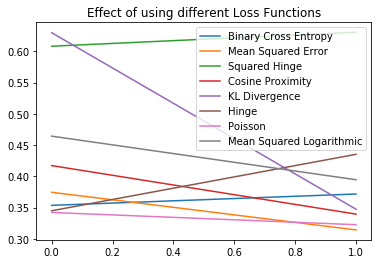

In [17]:
x = [i for i in range(len(losses[0]))]
print(len(x))
for i in range(len(losses)):
    print(losses[i])
    plt.plot(x,losses[i], label = names[i])
plt.title("Effect of using different Loss Functions")
plt.legend()
plt.show()